<h1 style="color:#ff5343; text-align:center">Twitter Sentiment Analysis Project</h1>

<h4 style = "text-align:right"> BY:- </h4>

In [115]:
#---Importing the standard libraries---

import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from datetime import datetime
from textblob import TextBlob
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 8,6
plt.style.use('ggplot')

In [2]:
#---Connecting to the Twitter API---

consumer_key = 'SAx9SLlWriEcqwQrohVvFW7IK'
consumer_secret = 'yj3EhFkmfXzpDSReGvHC5IPPhpadLt3cFMX0DXOzE7KBqqjoCm'

access_token = '905373434124746752-u8ADxykXGh4nAieqd4XCtT5NYN0ls6W'
access_token_secret = 'd1kVcM3t6pZdOKoNxsGbmhE5J6zQm4DAuW5a8XOUBbmmD'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [5]:
#---Connecting to a MongoDB client---

col = pymongo.MongoClient()['Tweets']['Streaming']
col.count()

0

In [6]:
#---Connecting to a Streaming Class---

class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=1000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        # Increment counter
        self.counter += 1
        
        # Store tweet to MongoDB
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
            #print("%s/%s" % (self.counter, self.max_tweets))
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=100)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

In [7]:
#---Connect to Streaming API---

keywords = ["#Trump"]
# Visualize a progress bar to track progress
progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)

# Start a filter with an error counter of 20
for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

Finished
Total Mining Time: 0:00:58.953125
Tweets/Sec: 1.7
Tweets collected: 100
Total tweets in collection: 100


In [80]:
#---Load Results in a DataFrame---

dataset = [{"Created_at": item["created_at"],
            "Text": item["text"],
            "User": "@%s" % item["user"]["screen_name"],
            "Language": item["user"]["lang"],
            "FollowerCount": item["user"]["followers_count"],
            "Following": item['user']['following'],
            "FriendsCount": item['user']['friends_count'],
            "Location": item["user"]["location"],
            "Source": item["source"]
           } for item in col.find()]

dataset = pd.DataFrame(dataset)
dataset.head()

,Created_at,FollowerCount,Following,FriendsCount,Language,Location,Source,Text,User
0,Tue Sep 26 15:28:19 +0000 2017,709,None,1869,en,"Yorkville, IL","<a href=""http://twitter.com/download/android"" ...",Anyone burning their #NFL gear in protest of p...,@KarateGomez
1,Tue Sep 26 15:28:19 +0000 2017,87,None,165,en,"Florida, USA","<a href=""http://twitter.com/download/iphone"" r...",@POTUS #STFU about the NFL. Lets put a rule so...,@valeriembp_
2,Tue Sep 26 15:27:28 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Trump says he'll visit Puerto Rico next Tuesda...,@USGovReport
3,Tue Sep 26 15:27:28 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Tillerson to meet top Cuba envoy amid probe in...,@USGovReport
4,Tue Sep 26 15:27:29 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Interior chief says third of employees not loy...,@USGovReport


In [66]:
# Preprocessing the Date (Created at)

dataset['Created_at'] = pd.to_datetime(dataset.Created_at)
dataset.head()

,Created_at,FollowerCount,Language,Location,Source,Text,User,Source_Name
0,2017-09-26 15:28:19,709,en,"Yorkville, IL","<a href=""http://twitter.com/download/android"" ...",Anyone burning their #NFL gear in protest of p...,@KarateGomez,Twitter for Android
1,2017-09-26 15:28:19,87,en,"Florida, USA","<a href=""http://twitter.com/download/iphone"" r...",@POTUS #STFU about the NFL. Lets put a rule so...,@valeriembp_,Twitter for iPhone
2,2017-09-26 15:27:28,686,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Trump says he'll visit Puerto Rico next Tuesda...,@USGovReport,IFTTT
3,2017-09-26 15:27:28,686,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Tillerson to meet top Cuba envoy amid probe in...,@USGovReport,IFTTT
4,2017-09-26 15:27:29,686,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Interior chief says third of employees not loy...,@USGovReport,IFTTT


In [117]:
# Getting the Source_Name from the Source

def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""

dataset['Source_Name'] = [get_source_name(x) for x in dataset['Source']]

---

## Word Count

In [49]:
#---Checking the highest used words---

cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.Text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50].head(8)

,word,count
0,trump,104
1,https,73
2,co,68
3,rt,51
4,it,42
5,is,34
6,the,27
7,nfl,25


## Word Cloud

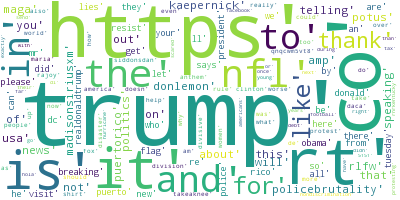

In [53]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=200)
ps = PorterStemmer()

words = [ps.stem(word) for word in word_count['word'] if not word in set(stopwords.words('english'))]
words = str(words)
wordcloud.to_image()

---

## Top 5 Sources for Tweets

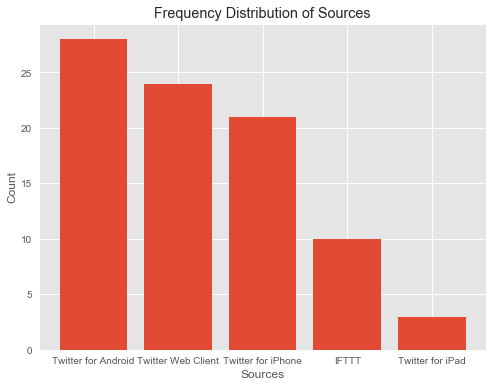

In [118]:
y = dataset.Source_Name.value_counts()[:5]
x = dataset.Source_Name.value_counts().index

plt.bar(list(range(len(y))),y)
plt.xticks(list(range(len(y))),x)
plt.xlabel('Sources')
plt.ylabel('Count')
plt.title('Frequency Distribution of Sources')
plt.show()

---

## Top 5 Languages

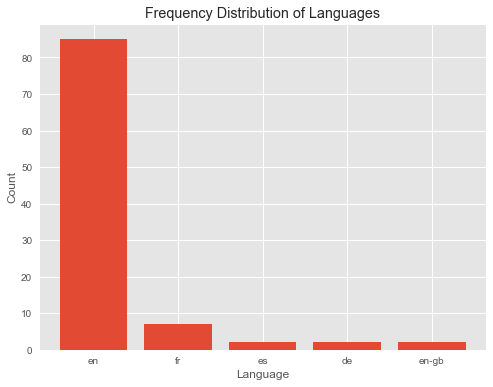

In [119]:
y = dataset.Language.value_counts()[:5]
x = dataset.Language.value_counts().index

plt.bar(list(range(len(y))),y)
plt.xticks(list(range(len(y))),x)
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Frequency Distribution of Languages')
plt.show()

---

## Top 5 Countries with Maximum Tweets

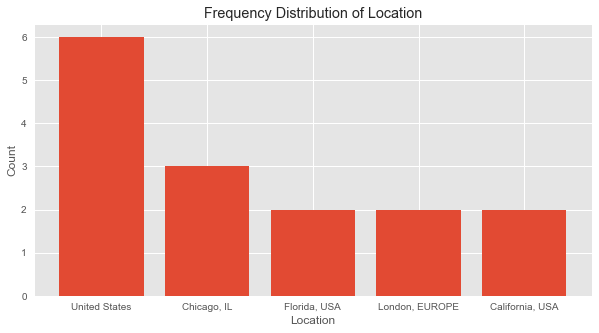

In [70]:
y = dataset.Location.value_counts()[:5]
x = dataset.Location.value_counts().index

plt.bar(list(range(len(y))),y)
plt.xticks(list(range(len(y))),x)
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Frequency Distribution of Location')
plt.show()

---

## User's Follower Count

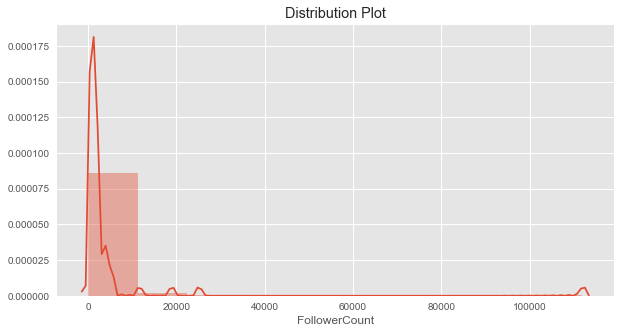

In [93]:
sns.distplot(dataset['FollowerCount'], bins=10)
plt.title('Distribution Plot')

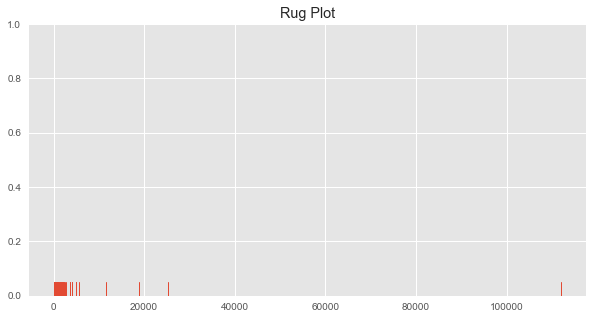

In [92]:
sns.rugplot(dataset['FollowerCount'])
plt.title("Rug Plot")

---

## Friends Count vs Followers Count

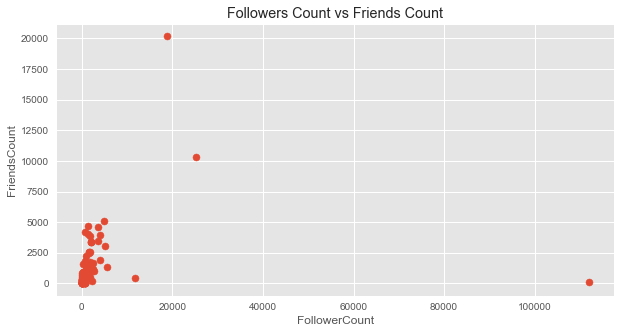

In [86]:
x = dataset.FollowerCount
y = dataset.FriendsCount
plt.scatter(x,y)
plt.xlabel('FollowerCount')
plt.ylabel('FriendsCount')
plt.title("Followers Count vs Friends Count")
plt.show()

---

In [94]:
# Distinct Number of Users

dataset.User.value_counts()

@USGovReport        6
@GrasslandDesign    3
@PoliKartoons       2
@TrumpsTrucker      1
@anitach2002        1
@2_twicks           1
@C_W_UK             1
@qavhasvdhsyh307    1
@skywaydirt         1
@amthouin           1
@bfzpeuqcnjqz241    1
@kchrystle          1
@miniestmini        1
@BeachWitchMagic    1
@johnlundin         1
@mykkool            1
@mariamcbean        1
@MyrlKimberely      1
@GregWhiz           1
@BillieHollywood    1
@d_key0207          1
@susan_donnally     1
@minouska_kounak    1
@Dougie_Ice_Back    1
@BraxtonBee         1
@Kjar1386           1
@tammi_song         1
@watchjbourne       1
@jakehammer59       1
@Write_Sense        1
                   ..
@TheCheesyChin      1
@AbleMarksman       1
@CaptainAlex8       1
@stringbeans15      1
@KarateGomez        1
@RobertLPhillip7    1
@IlonaBilli         1
@MissButter         1
@oidecnitsua        1
@CarolynHaley16     1
@nakanotekeko       1
@SusanS96965737     1
@valeriembp_        1
@maguilar63         1
@sarahyuro

---

In [95]:
def calc_polarity(i):
    tweet = TextBlob(dataset['Text'][i])
    return tweet.polarity

dataset['Sent_Polarity'] = [calc_polarity(i) for i in range(len(dataset))]

In [96]:
def calc_sub(i):
    tweet = TextBlob(dataset['Text'][i])
    return tweet.subjectivity

dataset['Sent_Subjectivity'] = [calc_sub(i) for i in range(len(dataset))]

In [97]:
dataset.head()

,Created_at,FollowerCount,Following,FriendsCount,Language,Location,Source,Text,User,Sent_Polarity,Sent_Subjectivity
0,Tue Sep 26 15:28:19 +0000 2017,709,None,1869,en,"Yorkville, IL","<a href=""http://twitter.com/download/android"" ...",Anyone burning their #NFL gear in protest of p...,@KarateGomez,-0.100000,0.191667
1,Tue Sep 26 15:28:19 +0000 2017,87,None,165,en,"Florida, USA","<a href=""http://twitter.com/download/iphone"" r...",@POTUS #STFU about the NFL. Lets put a rule so...,@valeriembp_,-0.287500,0.650000
2,Tue Sep 26 15:27:28 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Trump says he'll visit Puerto Rico next Tuesda...,@USGovReport,0.000000,0.000000
3,Tue Sep 26 15:27:28 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Tillerson to meet top Cuba envoy amid probe in...,@USGovReport,0.500000,0.500000
4,Tue Sep 26 15:27:29 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Interior chief says third of employees not loy...,@USGovReport,-0.083333,0.416667


In [107]:
def get_sentiment(i):
    if dataset['Sent_Polarity'][i] > 0:
        return 1
    elif dataset['Sent_Polarity'][i] < 0:
        return -1
    else:
        return 0

dataset['Sentiment'] = [get_sentiment(i) for i in range(len(dataset))]

In [108]:
dataset.head()

,Created_at,FollowerCount,Following,FriendsCount,Language,Location,Source,Text,User,Sent_Polarity,Sent_Subjectivity,Sentiment
0,Tue Sep 26 15:28:19 +0000 2017,709,None,1869,en,"Yorkville, IL","<a href=""http://twitter.com/download/android"" ...",Anyone burning their #NFL gear in protest of p...,@KarateGomez,-0.100000,0.191667,-1
1,Tue Sep 26 15:28:19 +0000 2017,87,None,165,en,"Florida, USA","<a href=""http://twitter.com/download/iphone"" r...",@POTUS #STFU about the NFL. Lets put a rule so...,@valeriembp_,-0.287500,0.650000,-1
2,Tue Sep 26 15:27:28 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Trump says he'll visit Puerto Rico next Tuesda...,@USGovReport,0.000000,0.000000,0
3,Tue Sep 26 15:27:28 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Tillerson to meet top Cuba envoy amid probe in...,@USGovReport,0.500000,0.500000,1
4,Tue Sep 26 15:27:29 +0000 2017,686,None,17,en,United States,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",Interior chief says third of employees not loy...,@USGovReport,-0.083333,0.416667,-1


---

## Pie Chart for Polarity

In [121]:
slices = dataset.Sentiment.value_counts()
activities = ['Neutral', 'Positive', 'Negative']

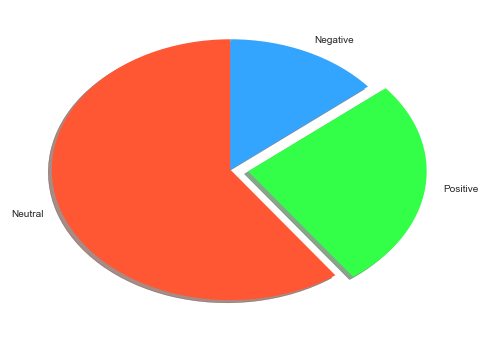

In [131]:
plt.pie(slices,labels=activities, colors=['#FF5733', '#33FF49', "#33A5FF"], shadow=True, explode=(0,0.1,0), startangle=90)
plt.show()

In [ ]:
###-----------------------THE END-----------------------------###

---